# Resize Image Dataset

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets

In [7]:
def create_files_dataFrame(root, classes):
    """
    Creates a pandas DataFrame for a image dataset of the form ./root/class/img.png

    Parameters
    ----------
    root: str
        The path to the dataset
    classes: iterable
        Containing the class names (folder names in the dataset)

    Returns
    ---------
    : pandas.DataFrame
    DataFrame with columns image for the file names of the images
    and label for the integer class label.
    """
    images = []
    labels = []
    for i, c in enumerate(classes):
        # get all image path for a class
        img_paths = glob.glob(os.path.join(root, f"{c}/*"))

        for img_path in img_paths:
            img_file = img_path.replace(os.path.join(root, f"{c}/"), '')
            images.append(img_file)
            labels.append(i)

    return pd.DataFrame.from_dict({'image': images, 'label': labels})

In [9]:
# path to the dataset
root = "./datasets/animals10/raw-img/"

# class names of the dataset
classes = [x[:-1].replace(root, '') for x in glob.glob(os.path.join(root, "*/"))]

# DataFrame of image file names
df_dataset = create_files_dataFrame(root, classes)

## Investigate Image Sizes

Plot the images sizes as scatter plot of width and height

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


<Axes: title={'center': 'Sizes < 1000'}, xlabel='width', ylabel='height'>

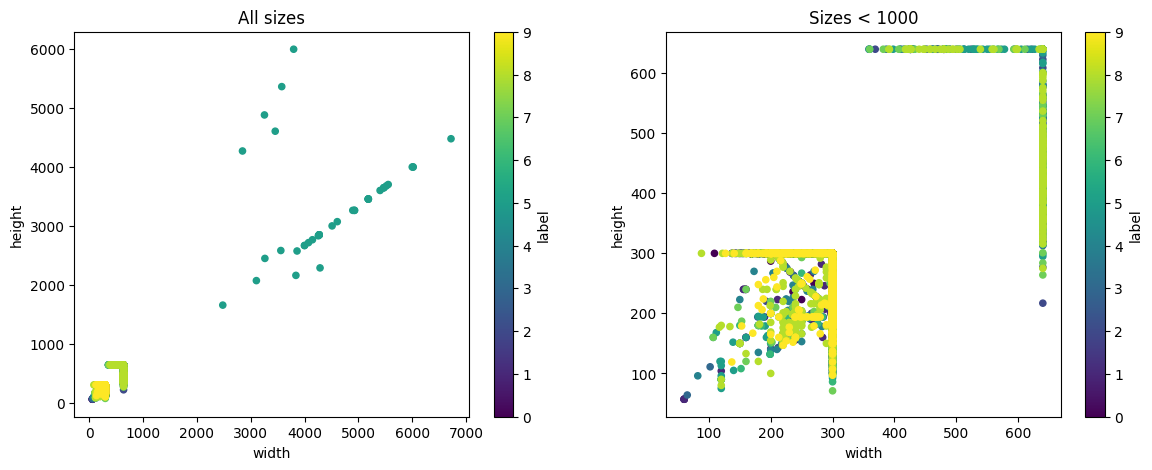

In [13]:
threshold = 1000

width = []
height = []
for i, c in enumerate(tqdm(classes)):
    for idx in df_dataset[df_dataset.label == i].index:
        img_path = os.path.join(root, f'{c}', df_dataset.iloc[idx,0])

        img = Image.open(img_path)
        width.append(img.size[0])
        height.append(img.size[1])

df_dataset["width"] = width
df_dataset["height"] = height

fig, axs = plt.subplots(ncols=2, figsize=(14,5))

df_dataset.plot.scatter(x='width', y='height', c='label', colormap='viridis', ax=axs[0], title="All sizes")
df_dataset[df_dataset.width < threshold].plot.scatter(x='width', y='height', c='label', colormap='viridis', ax=axs[1], title=f"Sizes < {threshold}")

## Resize the Images

Resize the data set to `size x size`, while keeping the proportions and than add padding.<br>
And also writ the resized dataset to `root_new`.

In [ ]:
root_new = "./datasets/animals10_300x300/train/"
size = 300

for i, c in enumerate(classes):
    os.makedirs(os.path.join(root_new, f'{c}'), exist_ok=True)
    for idx in tqdm(df_dataset[df_dataset.label == i].index):
        img_path = os.path.join(root, f'{c}', df_dataset.iloc[idx,0])

        img = Image.open(img_path)

        if img.size[0] >= size or img.size[0] >= size:
            img.thumbnail((size,size))
        else:
            if img.size[0] < img.size[1]:
                width = (img.size[0] * size) // img.size[1]
                height = size
            else:
                width = size
                height = (img.size[1] * size) // img.size[0]
            img = img.resize((width, height))

        img_pad = Image.new(img.mode, size=(size,size))
        start_y = (300 - img.size[0]+1) // 2
        start_x = (300 - img.size[1]+1) // 2
        img_pad.paste(img, (start_y, start_x))

        img_pad_path = os.path.join(root_new, f'{c}', df_dataset.iloc[idx,0])
        img_pad.save(img_pad_path)

## Check up-scaled Images

As the resizing scales images smaller than the target size up, what can lead to blurry images.

In [111]:
def get_upscaled_images(threshold = 200, root=root, root_new=root_new, classes=classes, df_dataset=df_dataset):
    images = []
    sizes = []
    for i, c in enumerate(tqdm(classes)):
        for idx in df_dataset[df_dataset.label == i].index:
            img_path = os.path.join(root, f'{c}', df_dataset.iloc[idx,0])
            img = Image.open(img_path)

            if max(img.size) < threshold:
                sizes.append(img.size)
                img_pad_path = os.path.join(root_new, f'{c}', df_dataset.iloc[idx,0])
                img_pad = Image.open(img_pad_path)
                images.append(img_pad)

    return images, np.array(sizes)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Text(0.5, 1.0, 'Sizes < 130')

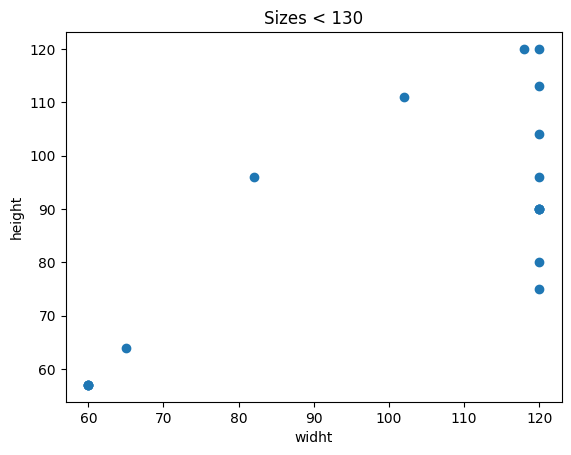

In [119]:
threshold = 130

images, sizes = get_upscaled_images(threshold=threshold)

plt.scatter(sizes[:,0], sizes[:,1])
plt.xlabel("widht")
plt.ylabel("height")
plt.title(f"Sizes < {threshold}")

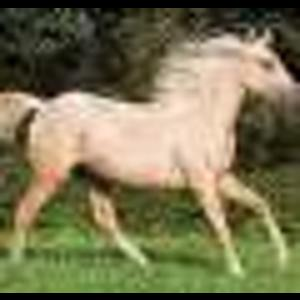

In [121]:
images[0]

## Get Mean and Standard Deviation of the Dataset

In [32]:
train_dataset = datasets.ImageFolder(root=root_new,
                                        transform=transforms.ToTensor())

train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=(train_sampler is None),
    num_workers=16, pin_memory=True, sampler=train_sampler)

In [33]:
images_list = []

for idx, (images, labels) in enumerate(tqdm(train_loader)):
    images_list.append(images)

all_images = torch.cat(images_list, dim=0)

mean = all_images.mean(dim=(0,2,3))
std = all_images.std(dim=(0,2,3))

print(f"mean: {mean}, std: {std}")

  0%|          | 0/1637 [00:00<?, ?it/s]

100%|██████████| 1637/1637 [01:25<00:00, 19.08it/s]


mean: tensor([0.3837, 0.3704, 0.3072]), std: tensor([0.3268, 0.3187, 0.3051])


## Train Test Split

Get some test data for validation.

In [17]:
def unite_dataset(root_train, train_loc="train", test_loc="test", classes=classes):
    """
    Unite train and test data

    Parameters
    -------------
    root_train: str
        Path to the training data
    train_loc: str
        Name of the folder holding the training data
    test_loc: str
        Name of the folder holding the test data
    classes: iterable
        Containing the class names
    """

    df_test = create_files_dataFrame(root_train.replace(train_loc, test_loc), classes=classes)

    for i, c in enumerate(tqdm(classes)):
        for idx in df_test[df_test.label == i].index:
            img_path = os.path.join(root_train.replace(train_loc, test_loc), f'{c}', df_test.iloc[idx,0])
            os.replace(img_path, img_path.replace(test_loc, train_loc))


def train_test_split(seed, root_train, test_frac=0.2, train_loc="train", test_loc="test", classes=classes):
    """
    Create a train-test split of a dataset

    Parameters
    -------------
    seed:
        Seed for random selection (can be None)
    root_train: str
        Path to the training data
    test_frac: float
        Fraction of the dataset that should become test data
    train_loc: str
        Name of the folder holding the training data
    test_loc: str
        Name of the folder holding the test data
    classes: iterable
        Containing the class names
    """
    
    walk = [x for x in os.walk(root_train.replace(train_loc, test_loc))]
    for f in walk[1:]:
        if len(f[2]) > 0:
            print("Reunite old tain-test split")
            unite_dataset(root_train, train_loc, test_loc, classes)
            break

    df_dataset = create_files_dataFrame(root_train, classes).sort_values(by=['label', 'image']).reset_index(drop=True)
    class_count = df_dataset.groupby("label").count()['image'].values
    df_sampler = pd.DataFrame.from_dict({"label": np.concatenate([[i]*c for i, c in enumerate(class_count)])})
    df_sampler['tmp'] = np.zeros(len(df_sampler))
    df_sample = df_sampler.groupby("label").sample(frac=test_frac, random_state=seed)
    print(f"Create train-test split (test frac: {test_frac}): train: {len(df_dataset)-len(df_sample)}, test: {len(df_sample)}")

    for i, c in enumerate(tqdm(classes)):
        os.makedirs(os.path.join(root_train.replace(train_loc, test_loc), f'{c}'), exist_ok=True)
        for idx in df_sample[df_sample.label == i].index:
            img_path = os.path.join(root_train, f'{c}', df_dataset.iloc[idx,0])
            os.replace(img_path, img_path.replace("train", "test"))


In [34]:
train_test_split(seed=5645, root_train=root_new, test_frac=0.2)

Create train-test split (test frac: 0.2): train: 20943, test: 5236


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


In [31]:
unite_dataset(root_train=root_new, train_loc="train", test_loc="test", classes=classes)

100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


-----------

In [31]:
root_orig = "./datasets/animals10_300x300/train/"
root_orig_test = "./datasets/animals10_300x300/test/"

root_n1 = "./datasets/animals10_diff/-1/train/"
root_4000 = "./datasets/animals10_diff/4000/train/"

root_n1_test = "./datasets/animals10_diff/-1/test/"
root_4000_test = "./datasets/animals10_diff/4000/test/"

In [34]:
unite_dataset(root_train=root_4000, train_loc="train", test_loc="test", classes=classes)

100%|██████████| 10/10 [00:00<00:00, 13.26it/s]


In [33]:
train_test_split(seed=5645, root_train=root_4000, test_frac=0.2)

Create train-test split (test frac: 0.2): train: 16115, test: 4030


 50%|█████     | 5/10 [00:00<00:00,  6.90it/s]


FileNotFoundError: [Errno 2] No such file or directory: './datasets/animals10_diff/4000/train/gatto/OIP-Y-jVYYnGQBpge8XkgNCMDQAAAA.jpeg' -> './datasets/animals10_diff/4000/test/gatto/OIP-Y-jVYYnGQBpge8XkgNCMDQAAAA.jpeg'

In [32]:
df_orig_test = create_files_dataFrame(root_orig_test, classes).sort_values(by=['label', 'image']).reset_index(drop=True)
df_n1_test = create_files_dataFrame(root_n1_test, classes).sort_values(by=['label', 'image']).reset_index(drop=True)

np.all((df_orig_test['image'] == df_n1_test['image']).values)

True

In [73]:
df_4000 = create_files_dataFrame(root_4000, classes).sort_values(by=['label', 'image']).reset_index(drop=True)
df_4000

,image,label
0,OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,0
2,OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,0
3,OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,0
4,OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg,0
...,...,...
20140,ef31b3092cf41c22d2524518b7444f92e37fe5d404b014...,8
20141,ef32b60929e90021d85a5854ee454296eb70e3c818b413...,8
20142,ef32b70c20e90021d85a5854ee454296eb70e3c818b413...,8
20143,ef35b70d2ce90021d85a5854ee454296eb70e3c818b413...,8


-------------

In [49]:
root_n1 = "/home/eheinert/data/Animals10-EEDv2/-1/"
root_200 = "/home/eheinert/data/Animals10-EEDv2/200/"
root_400 = "/home/eheinert/data/Animals10-EEDv2/400/"
root_1000 = "/home/eheinert/data/Animals10-EEDv2/1000/"
root_2000 = "/home/eheinert/data/Animals10-EEDv2/2000/"
root_3000 = "/home/eheinert/data/Animals10-EEDv2/3000/"
root_4000 = "/home/eheinert/data/Animals10-EEDv2/4000/"
root_5000 = "/home/eheinert/data/Animals10-EEDv2/5000/"
root_6000 = "/home/eheinert/data/Animals10-EEDv2/6000/"
root_7000 = "/home/eheinert/data/Animals10-EEDv2/7000/"
root_8000 = "/home/eheinert/data/Animals10-EEDv2/8000/"

roots = [root_n1, root_200, root_400, root_1000, root_2000, root_3000, root_4000, root_5000, root_6000, root_7000, root_8000]
diff_labels = [-1, 200, 400, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]

In [56]:
dfs = []
for i, root in enumerate(roots):
    df = create_files_dataFrame(root, classes)
    dfs.append(df)

    print(f"{diff_labels[i]}: number images {len(df)}")

-1: number images 26179
200: number images 20169
400: number images 20167
1000: number images 20166
2000: number images 20158
3000: number images 20153
4000: number images 20145
5000: number images 20138
6000: number images 20131
7000: number images 20122
8000: number images 20112


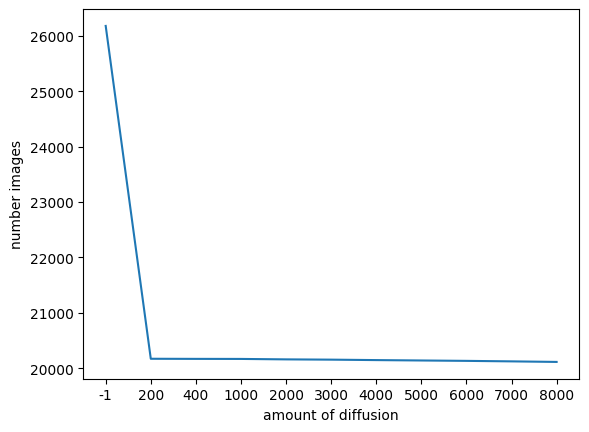

In [55]:
plt.plot([len(df) for df in dfs])
plt.xticks(np.arange(len(dfs)), labels=diff_labels)
plt.ylabel("number images")
plt.xlabel("amount of diffusion");

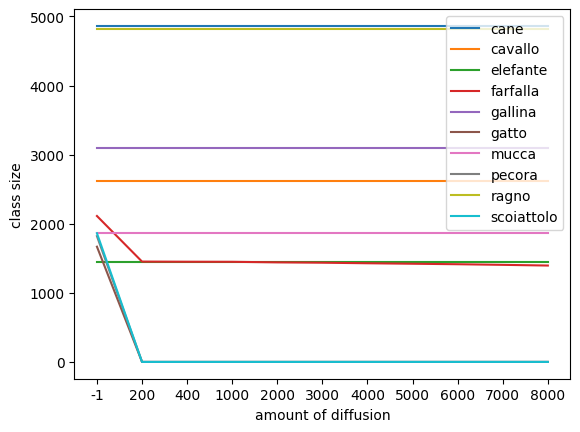

In [54]:
for l, c in enumerate(classes):
    plt.plot([len(df.query(f"label == {l}")) for df in dfs], label=c)
plt.legend()
plt.xticks(np.arange(len(dfs)), labels=diff_labels)
plt.ylabel("class size")
plt.xlabel("amount of diffusion");

In [78]:
dfs[0].groupby('label').count() - dfs[np.where(np.array(diff_labels) == 4000)[0][0]].groupby('label').count()

,image
label,
0,0.0
1,0.0
2,0.0
3,684.0
4,0.0
5,NaN
6,0.0
7,NaN
8,0.0


--------

eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png

In [32]:
import numpy as np
from PIL import Image
from torchvision import transforms, datasets

In [2]:
farfalla_img_orig = "./datasets/animals10_300x300/train/farfalla/eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png"

farfalla_img_n1 = "./datasets/animals10_diff/-1/train/farfalla/eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png"

In [10]:
root_orig = "./datasets/animals10_300x300/train/"

df_orig_train = create_files_dataFrame(root_orig, classes).sort_values(by=['label', 'image']).reset_index(drop=True)

In [14]:
root_orig_test = "./datasets/animals10_300x300/test/"

df_orig_test = create_files_dataFrame(root_orig_test, classes).sort_values(by=['label', 'image']).reset_index(drop=True)

In [31]:
for i, path in enumerate(df_orig_train['image'].values):
    img_shape = np.asarray(Image.open(os.path.join(root_orig, classes[df_orig_train.loc[i].label], path))).shape
    if img_shape[-1] != 3:
        print(i, img_shape)

6874 (300, 300, 4)
6875 (300, 300, 4)
6876 (300, 300, 4)
6877 (300, 300, 4)
6903 (300, 300)
6909 (300, 300, 4)
6937 (300, 300, 4)
6938 (300, 300, 4)
7076 (300, 300, 4)
8473 (300, 300, 4)
8474 (300, 300, 4)
8484 (300, 300, 4)
8511 (300, 300, 4)
8557 (300, 300, 4)
8710 (300, 300, 4)
8769 (300, 300, 4)
8770 (300, 300, 4)
8771 (300, 300, 4)
8778 (300, 300, 4)
8779 (300, 300, 4)
8780 (300, 300, 4)
8783 (300, 300, 4)
8784 (300, 300, 4)
8786 (300, 300, 4)
8787 (300, 300, 4)
8788 (300, 300, 4)
8789 (300, 300, 4)
8790 (300, 300, 4)
8792 (300, 300, 4)
8800 (300, 300, 4)
8801 (300, 300, 4)
8802 (300, 300, 4)
8803 (300, 300, 4)
8804 (300, 300, 4)
8805 (300, 300, 4)
8812 (300, 300, 4)
8814 (300, 300, 4)
8815 (300, 300, 4)
19420 (300, 300, 4)


6874 (300, 300, 4) OK
6875 (300, 300, 4) OK
6876 (300, 300, 4) OK
6877 (300, 300, 4) OK
6903 (300, 300)    OK
6909 (300, 300, 4) OK
6937 (300, 300, 4) OK
6938 (300, 300, 4) OK
7076 (300, 300, 4) OK
8473 (300, 300, 4) OK
8474 (300, 300, 4) OK
8484 (300, 300, 4) OK
8511 (300, 300, 4) OK
8557 (300, 300, 4) OK
8710 (300, 300, 4) OK
8769 (300, 300, 4) OK
8770 (300, 300, 4) OK
8771 (300, 300, 4) OK
8778 (300, 300, 4) OK
8779 (300, 300, 4) OK
8780 (300, 300, 4) OK
8783 (300, 300, 4) OK
8784 (300, 300, 4) OK
8786 (300, 300, 4) OK
8787 (300, 300, 4) OK
8788 (300, 300, 4) OK
8789 (300, 300, 4) OK
8790 (300, 300, 4) OK
8792 (300, 300, 4) OK
8800 (300, 300, 4) OK
8801 (300, 300, 4) OK
8802 (300, 300, 4) OK
8803 (300, 300, 4) black
8804 (300, 300, 4) OK
8805 (300, 300, 4) OK
8812 (300, 300, 4) OK
8814 (300, 300, 4) OK
8815 (300, 300, 4) OK
19420 (300, 300, 4) OK


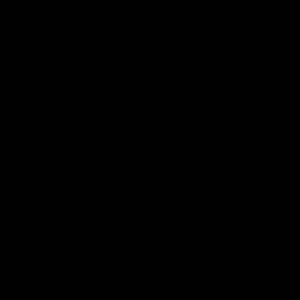

In [78]:
idx = 8803
datasets.folder.default_loader(os.path.join(root_orig, classes[df_orig_train.loc[idx].label], df_orig_train.loc[idx].image))

In [38]:
for i, path in enumerate(df_orig_test['image'].values):
    img_shape = np.asarray(Image.open(os.path.join(root_orig_test, classes[df_orig_test.loc[i].label], path))).shape
    if img_shape[-1] != 3:
        print(i, img_shape)

1748 (300, 300, 4)
2117 (300, 300, 4)
2155 (300, 300, 4)
2173 (300, 300, 4)
2192 (300, 300, 4)
2193 (300, 300, 4)
2195 (300, 300, 4)
2196 (300, 300, 4)
2197 (300, 300, 4)
2198 (300, 300, 4)
2203 (300, 300, 4)
3076 (300, 300, 4)


1748 (300, 300, 4) OK
2117 (300, 300, 4) OK
2155 (300, 300, 4) OK
2173 (300, 300, 4) OK
2192 (300, 300, 4) OK
2193 (300, 300, 4) OK
2195 (300, 300, 4) OK
2196 (300, 300, 4) OK
2197 (300, 300, 4) OK
2198 (300, 300, 4) OK
2203 (300, 300, 4) OK
3076 (300, 300, 4) OK

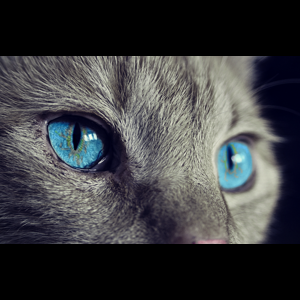

In [92]:
idx = 3076
datasets.folder.default_loader(os.path.join(root_orig_test, classes[df_orig_test.loc[idx].label], df_orig_test.loc[idx].image))

In [23]:
for i, path in enumerate(df_orig_train['image'].values):
    if path == "eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png":
        print(i)
        break

8803


In [24]:
df_orig_train.loc[8803].image

'eb35b30729f1073ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.png'

In [3]:
np.asarray(Image.open(farfalla_img_orig)).shape

(300, 300, 4)

In [13]:
np.asarray(Image.open(farfalla_img_n1)).shape

(300, 300, 3)